# return study

In [473]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [438]:
os.environ.get("SPICE")

'/home/yuri/Documents/spice'

In [445]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [446]:
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "spk", "de440.bsp"))
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "lsk", "naif0012.tls"))

In [447]:
ssdict = pxp.solar_system_spice()
ssdict["earth"]

Planet Name: 3, SUN, ECLIPJ2000
Own gravity parameter: 398600441800000
Central body gravity parameter: 1.32712440018e+20
Planet radius: 6378000
Planet safe radius: 6696900
Target planet: 3
Observer: SUN
Reference frame: ECLIPJ2000
Aberrations: NONE
Ephemerides type: SPICE Toolbox

In [448]:
epoch(13000,"mjd2000"), epoch(15000,"mjd2000")

(2035-Aug-05 00:00:00, 2041-Jan-25 00:00:00)

In [456]:
pk.epoch_from_string('2039-01-20 23:59:54.003').mjd
pk.epoch_from_string('2040-01-20 23:59:54.003').mjd

58868.999930590275

In [576]:
year_2039_mjd = np.linspace(
    pk.epoch_from_string('2039-01-01 23:59:54.003').mjd,
    pk.epoch_from_string('2040-01-01 23:59:54.003').mjd,
    100
)

In [577]:
SUN_EXCLUSION_ANGLE = 30 * np.pi/180   # TBC!!!

r_earth = np.zeros((3,len(year_2039_mjd)))
r_saturn = np.zeros((3,len(year_2039_mjd)))
phis = []
distance_Earth_Saturn = []

visible_epochs = []
nonvisible_epochs = []

for idx,epoch_test in enumerate(year_2039_mjd):
    rE,_ = ssdict["earth"].eph(epoch_test)
    r_earth[:,idx] = rE
    rS,_ = ssdict["saturn"].eph(epoch_test)
    r_saturn[:,idx] = rS
    
    # store distance
    distance_Earth_Saturn.append(la.norm(r_E_Sat))
    
    # vector Earth -> Sun and Earth -> Saturn
    r_E_Sun = -np.array(rE)
    r_E_Sat = np.array(rS) - np.array(rE)
    
    # check for Sun exclusion angle
    phi_check = np.arccos(
        np.dot(rE, rS)/(la.norm(rE)*la.norm(rS))
        #np.dot(r_E_Sun, r_E_Sat)/(la.norm(r_E_Sun)*la.norm(r_E_Sat))
    )
    phis.append(phi_check)
    
    # phis
    earth_sun_saturn_angle = np.dot(np.array(rE), np.array(rS))/(la.norm(np.array(rE))*la.norm(np.array(rS)))
    
#     if earth_sun_saturn_angle <= np.pi/2:
#         # visible automatically
#         visible_epochs.append(
#             (epoch_test, np.array(rE), np.array(rS))
#         )
#     else:
    # check angle
    if phi_check < np.pi - SUN_EXCLUSION_ANGLE/2:
        # visible
        visible_epochs.append(
            (epoch_test, np.array(rE), np.array(rS))
        )
    else:
        # not visible
        nonvisible_epochs.append(
            (epoch_test, np.array(rE), np.array(rS))
        )

In [578]:
SUN_EXCLUSION_ANGLE

0.5235987755982988

In [579]:
len(nonvisible_epochs)

9

<IPython.core.display.Javascript object>


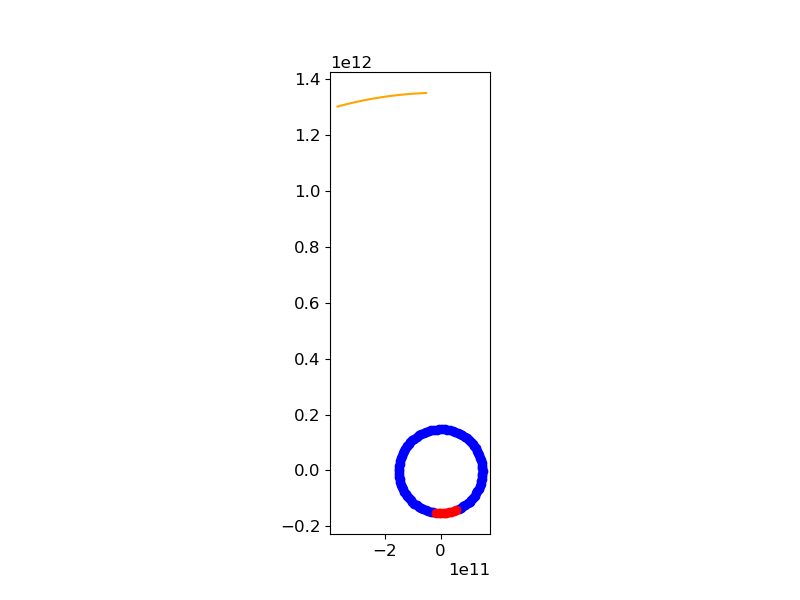

In [587]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#ax.plot(r_earth[0,:], r_earth[1,:], c="blue")
ax.plot(r_saturn[0,:], r_saturn[1,:], c="orange")

x_plot, y_plot = [], []
for vis in visible_epochs:
    x_plot.append(vis[1][0])
    y_plot.append(vis[1][1])
ax.scatter(x_plot, y_plot, c="blue")
    
x_plot, y_plot = [], []
for vis in nonvisible_epochs:
    x_plot.append(vis[1][0])
    y_plot.append(vis[1][1])
ax.scatter(x_plot, y_plot, c="red")
    
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


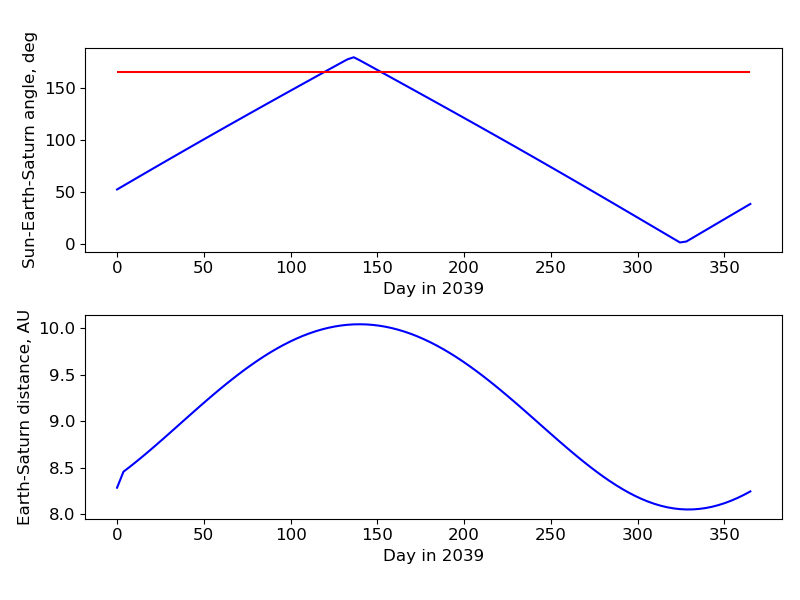

In [593]:
fig, axs = plt.subplots(2,1,figsize=(8,6))
axs[0].plot(year_2039_mjd-year_2039_mjd[0], np.array(phis)*180/np.pi, c="blue")
axs[0].set(xlabel="Day in 2039", ylabel="Sun-Earth-Saturn angle, deg")
axs[0].hlines(
    (np.pi - SUN_EXCLUSION_ANGLE/2)*180/np.pi,
    min(year_2039_mjd)-year_2039_mjd[0],
    max(year_2039_mjd)-year_2039_mjd[0],
    color='red',
)

axs[1].plot(year_2039_mjd-year_2039_mjd[0], np.array(distance_Earth_Saturn)/pk.AU, c="blue")
axs[1].set(xlabel="Day in 2039", ylabel="Earth-Saturn distance, AU")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [558]:
# seq = [
#     ssdict['saturn'],
#     ssdict['saturn'],
#     ssdict['earth']
# ]

# prob_return = pk.trajopt.mga_1dsm(
#     seq = seq,
#     t0 = [
#         #epoch(12000,"mjd2000"),
#         #epoch(13000,"mjd2000"),
#         pk.epoch_from_string('2020-01-20 23:59:54.003').mjd,
#         pk.epoch_from_string('2030-01-20 23:59:54.003').mjd
#     ], 
#     tof = [
#         [2/pk.DAY2YEAR, 6/pk.DAY2YEAR],
#         [3/pk.DAY2YEAR, 6/pk.DAY2YEAR],
#     ], 
#     vinf = [0.0, 0.0], 
#     multi_objective = False, 
#     add_vinf_dep = True, 
#     add_vinf_arr = False,
#     tof_encoding = 'direct'
# )

In [594]:
# prob_return.fitness(pop.champion_x)

In [407]:
algo = pg.algorithm(pg.sade(gen=4000))

In [595]:
# print("Evolving...")
# pop = pg.population(prob=prob_return, size=30)
# pop = algo.evolve(pop)
# print("Done!")

In [678]:
def iterate_launch_windows(seq, t0, tof):
    prob_iter = pk.trajopt.mga_1dsm(
        seq = seq,
        t0 = t0,
        tof=tof,
        vinf = [0.0, 0.0], 
        multi_objective = False, 
        add_vinf_dep = True, 
        add_vinf_arr = True,
        tof_encoding = 'direct'
    )
    pop = pg.population(prob=prob_iter, size=10)
    algo = pg.algorithm(pg.sade(gen=2000))
    pop = algo.evolve(pop)
    return prob_iter, pop

In [679]:
pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000

16071.0

In [680]:
epoch(16071,"mjd2000")

2044-Jan-01 00:00:00

In [681]:
tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR],
    [3/pk.DAY2YEAR, 6/pk.DAY2YEAR],
]

pop_list = []
prop_list = []

for i_window in tqdm(range(50)):
    t0_iter = [
        pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*100,
        pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*100
        
    ]
    prob_iter, pop = iterate_launch_windows(seq, t0_iter, tof)
    try:
        pop_list.append(pop)
        prop_list.append(prob_iter)
    except:
        print(f"Failed at window {i_window}")

  0%|          | 0/50 [00:00<?, ?it/s]

In [682]:
# get combined list of xs and fs
for idx,pop_iter in enumerate(pop_list):
    if idx == 0:
        x_combined = pop_iter.get_x()
        f_combined = pop_iter.get_f()
    else:
        x_combined = np.concatenate((x_combined, pop_iter.get_x()),axis=0)
        f_combined = np.concatenate((f_combined, pop_iter.get_f()))

In [683]:
xbest = x_combined[np.argmin(f_combined),:]

<IPython.core.display.Javascript object>


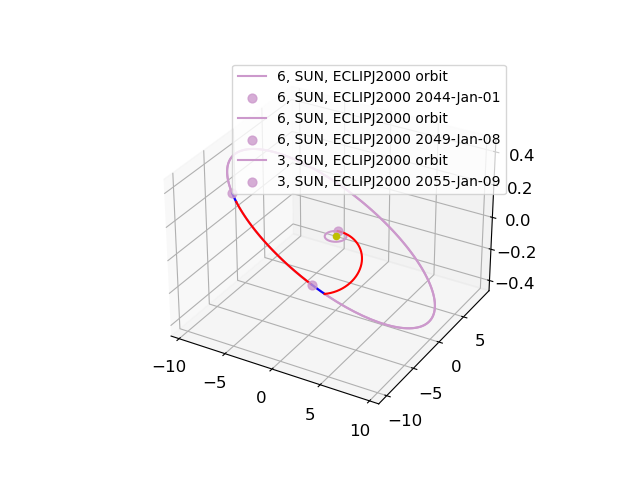

In [684]:
ax = prop_list[0].plot(xbest)

In [685]:
#pop_iter.get_x()

In [686]:
x_combined.shape

(500, 10)

In [687]:
t = prob_return.pretty(pop.champion_x)

First Leg: 6, SUN, ECLIPJ2000 to 6, SUN, ECLIPJ2000
Departure: 2057-Sep-08 23:58:41.670904 (21070.999093413244 mjd2000) 
Duration: 1376.3403171089349days
VINF: 0.0 km/sec
DSM after 137.63403171138242 days
DSM magnitude: 25.072876921210103m/s

leg no. 2: 6, SUN, ECLIPJ2000 to 3, SUN, ECLIPJ2000
Duration: 2191.499932683591days
Fly-by epoch: 2061-Jun-16 08:08:45.069116 (22447.339410522178 mjd2000) 
Fly-by radius: 29.99999999947121 planetary radii
DSM after 422.3841047079703 days
DSM magnitude: 6016.684008197306m/s

Arrival at 3, SUN, ECLIPJ2000
Arrival epoch: 2067-Jun-16 20:08:39.252979 (24638.83934320577 mjd2000) 
Arrival Vinf: 10726.411791651853m/s
Total mission time: 9.76821423625606 years (3567.840249792526 days)


In [688]:
prob_iter._add_vinf_arr = False
prob_iter.fitness(pop.champion_x)

(6041.756885118516,)

In [689]:
prob_iter._add_vinf_arr = True
prob_iter.fitness(pop.champion_x)

(16768.16867677037,)

In [695]:
len(pop.champion_x)

10

```
direct encoding: [t0] + [u, v, Vinf, eta1, T1] + [beta, rp/rV, eta2, T2] + ... 
```

In [690]:
def porkchop_process(prob_iter, pop_x, pop_f):
    # extract from decision vector
    data = {
        "t0": [],
        "tof_total": [],
        "dsm_total": [],
        "arrival_deltaV": [],
        "f": []
    }
    for idx, x in enumerate(pop_x):
        data["t0"].append(x[0])
        # get tof
        tof_total = x[5]
        for i_leg in range(len(seq)-2):
            tof_total += x[5+4*(i_leg+1)]
        data["tof_total"].append(tof_total)
        # objective
        data["f"].append(pop_f[idx])
        
        # compute objective without and with arrival delta-V
        prob_iter._add_vinf_arr = False
        dsm_total = prob_iter.fitness(x)[0]
        prob_iter._add_vinf_arr = True
        dv_total = prob_iter.fitness(x)[0]
        
        # arrival delta-V
        arrival_deltaV = dv_total - dsm_total
        
        # store
        data["dsm_total"].append(dsm_total)
        data["arrival_deltaV"].append(arrival_deltaV)
        
    # convert to numpy array
    data["t0"] = np.array(data["t0"])
    data["tof_total"] = np.array(data["tof_total"])
    data["dsm_total"] = np.array(data["dsm_total"])
    data["arrival_deltaV"] = np.array(data["arrival_deltaV"])
    data["f"] = np.array(data["f"])
    return data

In [691]:
porkchop_return = porkchop_process(x_combined, f_combined)
#porkchop_return = porkchop_process(pop.get_x(), pop.get_f())

In [707]:
pk.epoch(porkchop_return["t0"][0]).__str__()[0:11]

'2044-Jan-02'

In [692]:
seq_name = ""
for se in seq:
    seq_name += se.name + "-"
seq_name = seq_name[:-1]
seq_name

'6, SUN, ECLIPJ2000-6, SUN, ECLIPJ2000-3, SUN, ECLIPJ2000'

In [693]:
seq_name = "saturn-saturn-earth"

<IPython.core.display.Javascript object>


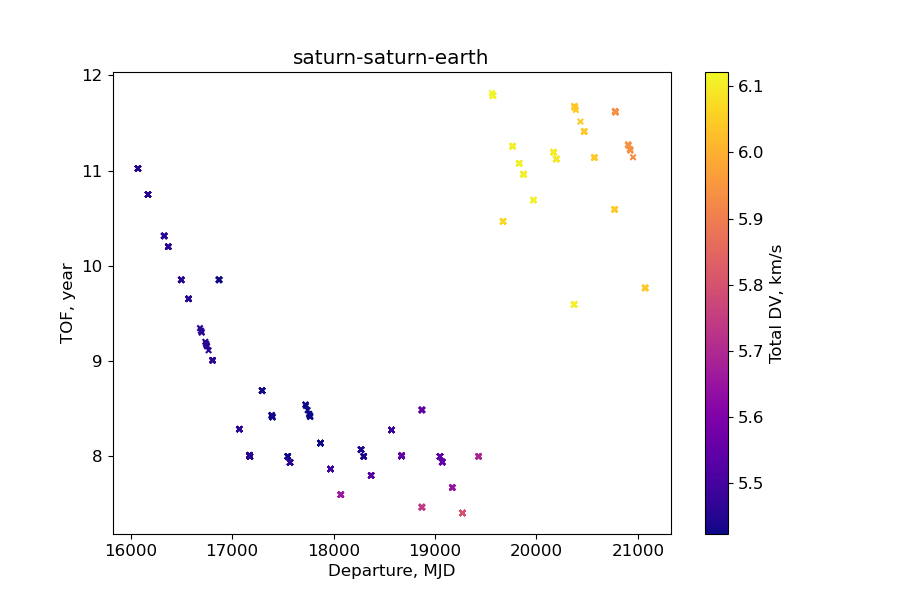

In [694]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1,1,figsize=(9,6))

im0 = ax.scatter(porkchop_return['t0'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['dsm_total']/1e3, cmap='plasma', s=15, marker='x')

fig.colorbar(im0, label='Total DV, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure, MJD", ylabel="TOF, year")

plt.show()

In [676]:
epoch(68000,"mjd2000"), epoch(16000,"mjd2000")

(2186-Mar-06 00:00:00, 2043-Oct-22 00:00:00)

```
pykep.planet.keplerian(when,r,v, mu_central_body, mu_self,radius, safe_radius [, name = 'unknown'])
```

In [677]:
fig.savefig("./plots/return_pc_"+seq_name+".png")

In [187]:
# prob_return.plot(pop.champion_x)
# plt.show()